### PuLP 

In [ ]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the LP problem
model = lp.LpProblem("Wagner_Model", lp.LpMinimize)

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
X = lp.LpVariable.dicts("X", (range(M), range(N)), lowBound=0, cat='Integer')
Y = lp.LpVariable.dicts("Y", (range(M), range(N)), lowBound=0, cat='Integer')

# Define the objective function
model += lp.lpSum(T[i][M - 1] for i in range(N)) + lp.lpSum(X[i][M - 1] for i in range(N))

# Define the constraints
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

for r in range(M - 1):
    for j in range(N - 1):
        model += lp.lpSum(T[i][r] * Z[i][j + 1] for i in range(N)) - lp.lpSum(T[i][r + 1] * Z[i][j] for i in range(N)) + \
                  X[j + 1][r] - X[j + 1][r + 1] + Y[j + 1][r] - Y[j][r] == 0

for r in range(M - 1):
    model += lp.lpSum(T[i][r] * Z[i][0] for i in range(N)) +  X[0][r] - X[0][r + 1] + Y[0][r] == 0

# Solve the LP problem
solution = model.solve()

# Print the optimal solution
print("Objective Value:", lp.value(model.objective))

# Carta Gannt
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = lp.value(model.objective)
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

matriz = [[0 for x in range(N)] for y in range(M)]
for i in range(M):
    inicio = lp.value(X[0][i])
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (i > 0):
            if(matriz[i-1][j][1] > inicio):
                inicio += lp.value(X[j][i])
        termino = inicio + duracion_tarea
        matriz[i][j] = [int(inicio), int(termino)]
        inicio = termino

for i in range(M):
    for j in range(N):
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        inicio = matriz[i][j][0]
        duracion_tarea = matriz[i][j][1] - matriz[i][j][0]
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')

### CPLEX

In [ ]:
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import numpy as np

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the model
model = Model(name="Wagner_Model")

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines

Z = {(i, j): model.binary_var(name=f"Z_{i}_{j}") for i in range(N) for j in range(M)}
X = {(i, j): model.integer_var(name=f"X_{i}_{j}", lb=0) for i in range(N) for j in range(M)}
Y = {(i, j): model.integer_var(name=f"Y_{i}_{j}", lb=0) for i in range(N) for j in range(M)}

# Define the objective function
model.minimize(model.sum(T[i][M - 1] * Z[i, j] for i in range(N) for j in range(M)) +
               model.sum(X[i, M - 1] for i in range(N)))

# Define the constraints
for i in range(N):
    model.add_constraint(model.sum(Z[i, j] for j in range(N)) == 1)
    
for j in range(N):
    model.add_constraint(model.sum(Z[i, j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.add_constraint(model.sum(T[i][r] * Z[i, j + 1] for i in range(N)) -
                             model.sum(T[i][r + 1] * Z[i, j] for i in range(N)) +
                             X[j + 1, r] - X[j + 1, r + 1] + Y[j + 1, r] - Y[j, r] == 0)

for r in range(M - 1):
    model.add_constraint(model.sum(T[i][r] * Z[i, 0] for i in range(N)) +
                         X[0, r] - X[0, r + 1] + Y[0, r] == 0)

# Solve the model
solution = model.solve()
# Print the optimal solution
print("Objective Value:", solution.get_objective_value())

# Carta Gannt
unos_tareas = [(i, j) for i in range(N) for j in range(N) if solution.get_value(Z[i, j]) == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = solution.get_objective_value()
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

for i in range(M):
    inicio = solution.get_value(X[0, i])
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')
        inicio += duracion_tarea

### Gurobi

Objective Value: 105.0


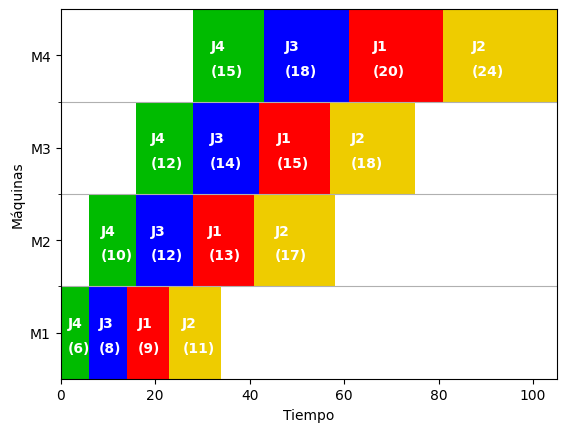

In [3]:
import gurobipy as gp
import numpy as np
import matplotlib.pyplot as plt

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the model
model = gp.Model("Wagner_Model")

# Define the decision variables
N = len(T)  # Number of jobs
M = len(T[0])  # Number of machines
Z = model.addVars(N, N, vtype=gp.GRB.BINARY, name="Z")
X = model.addVars(M, N + 1, vtype=gp.GRB.INTEGER, lb=0, name="X")
Y = model.addVars(M, N + 1, vtype=gp.GRB.INTEGER, lb=0, name="Y")

# Define the objective function
model.setObjective(gp.quicksum(T[i][M - 1] * Z[i, j] for i in range(N) for j in range(M)) +
                   gp.quicksum(X[i, M - 1] for i in range(N)), gp.GRB.MINIMIZE)

# Define the constraints
for i in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for j in range(N)) == 1)
    
for j in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.addConstr(gp.quicksum(T[i][r] * Z[i, j + 1] for i in range(N)) -
                        gp.quicksum(T[i][r + 1] * Z[i, j] for i in range(N)) +
                        X[j + 1, r] - X[j + 1, r + 1] + Y[j + 1, r] - Y[j, r] == 0)

for r in range(M - 1):
    model.addConstr(gp.quicksum(T[i][r] * Z[i, 0] for i in range(N)) +
                    X[0, r] - X[0, r + 1] + Y[0, r] == 0)

# Solve the model
model.setParam('OutputFlag', False)
model.optimize()

# Print the optimal solution
print("Objective Value:", model.objVal)

# Carta Gannt
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].x == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = model.objVal
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

for i in range(M):
    inicio = X[0, i].x
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')
        inicio += duracion_tarea